In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
def create_graph_data(df, node_list):
    # Create a mapping of node names to indices
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Convert edges to indices
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T  # Transpose to get the shape [2, num_edges]

    # Node features (converted to numpy array or tensor)
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float32)

    # Labels (0 for non-fraud, 1 for fraud)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)

    return node_features, edge_index, labels, node_map


In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
node_features, edge_index, labels, node_map = create_graph_data(df, node_list)

In [7]:
# Plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

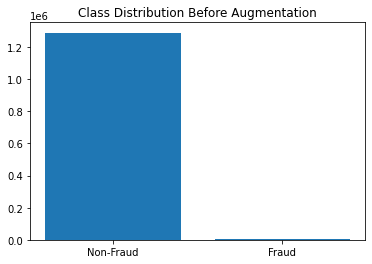

In [8]:
plot_class_distribution(labels, "Class Distribution Before Augmentation")

In [9]:
def build_adjacency_matrix(edge_index, num_nodes):
    # Use a sparse tensor if the graph is large
    adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)  # For unweighted edges

    # Efficiently assign edges
    row_indices = edge_index[0].long()  # Ensure indices are of type long
    col_indices = edge_index[1].long()
    
    adj[row_indices, col_indices] = 1  # Set values to 1 for edges

    return adj

In [10]:
def normalize_adj(adj):
    degree = torch.sum(adj, dim=1)  # Compute degree (sum of rows)
    degree_inv_sqrt = torch.diag(torch.pow(degree, -0.5))
    adj_normalized = degree_inv_sqrt @ adj @ degree_inv_sqrt  # Symmetric normalization
    return adj_normalized

In [11]:
# Implement GCN layer manually
class SimpleGCNLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleGCNLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, x, adj):
        x = torch.relu(self.fc(adj @ x))  # Graph convolution using dense adjacency matrix
        return x

In [12]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # Graph convolution: x' = ReLU(Adjacency_matrix * x * Weights)
        x = torch.matmul(adj, x)  # Multiply adjacency matrix by input feature matrix
        x = self.fc(x)  # Apply the linear transformation (weights)
        return torch.relu(x)  # Apply ReLU activation

In [13]:
class WGANGeneratorWithManualGCN(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_nodes, adj):
        super(WGANGeneratorWithManualGCN, self).__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.gcn1 = GCNLayer(hidden_size, hidden_size)  # GCN Layer 1
        self.gcn2 = GCNLayer(hidden_size, hidden_size)  # GCN Layer 2
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.adj = adj  # Store adjacency matrix (should be in the correct format)
        self.num_nodes = num_nodes  # Total number of nodes in the graph

    def forward(self, z):
        # Pass through the first fully connected layer
        z = torch.relu(self.fc1(z))
        
        # Create sparse adjacency matrix
        adj = self.build_sparse_adjacency_matrix(self.adj, self.num_nodes)
        adj = self.normalize_sparse_adj(adj)  # Normalize the adjacency matrix
        z = z[:self.num_nodes]  # Adjust size of z to match the number of nodes
        
        # Pass through GCN layers
        z = self.gcn1(z, adj)  # Graph convolution using the expanded adjacency matrix
        z = self.gcn2(z, adj)
        
        # Final output layer
        return self.fc2(z)

    def build_sparse_adjacency_matrix(self, edge_index):
        # Ensure edge_index is a LongTensor with shape (2, num_edges)
        if isinstance(edge_index, torch.Tensor):
            edge_index = edge_index.long()  # Ensure it's a LongTensor
        else:
            edge_index = torch.tensor(edge_index, dtype=torch.long)

        # Transpose edge_index to shape (2, num_edges)
        indices = edge_index.t()  # Transpose to get the right shape

        # Values should be 1s for unweighted edges
        values = torch.ones(indices.shape[1], dtype=torch.float32)  # Values match number of edges

        # Create the sparse adjacency matrix
        adj_sparse = torch.sparse_coo_tensor(indices, values, (self.num_nodes, self.num_nodes))
        return adj_sparse

    def normalize_sparse_adj(self, adj):
        # Compute degree matrix
        degree = torch.sparse.sum(adj, dim=1).to_dense()
        degree_inv_sqrt = torch.pow(degree, -0.5)
        degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0  # Avoid division by zero

        # Apply normalization: D^(-1/2) * A * D^(-1/2)
        adj_normalized = adj.coalesce()  # Ensures indices are sorted, necessary for sparse tensor operations
        adj_normalized = adj_normalized * degree_inv_sqrt.unsqueeze(0) * degree_inv_sqrt.unsqueeze(1)
        return adj_normalized

In [14]:
class WGANDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WGANDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)  # LeakyReLU for better gradient flow

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        return self.fc2(x)  # No activation, return raw score

In [15]:
# WGAN training
def train_wgan(generator, discriminator, num_epochs, data_loader, d_optimizer, g_optimizer, z_dim, device):
    for epoch in range(num_epochs):
        for i, data in enumerate(data_loader):
            real_data = data.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            z = torch.randn(real_data.size(0), z_dim).to(device)  # Latent vector
            fake_data = generator(z).detach()  # Generate fake data and detach
            real_loss = discriminator(real_data).mean()
            fake_loss = discriminator(fake_data).mean()
            d_loss = fake_loss - real_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_data = generator(z)  # Generate fake data
            g_loss = -discriminator(fake_data).mean()  # Generator loss
            g_loss.backward()
            g_optimizer.step()

            # Logging
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

In [ ]:
latent_size = 64  # Latent space dimension
hidden_size = 64   # Hidden layer size
output_size = node_features.size(1)  # Output size matches the input feature size
num_nodes = node_features.size(0)  # Number of nodes in the graph
adj_matrix = build_adjacency_matrix(edge_index, num_nodes)  # Create the adjacency matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = WGANGeneratorWithManualGCN(latent_size, hidden_size, output_size, num_nodes, adj_matrix).to(device)
discriminator = WGANDiscriminator(output_size, hidden_size).to(device)

In [ ]:
# Optimizers
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

In [ ]:
# Data Loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(node_features, batch_size=batch_size, shuffle=True)

In [ ]:
# Train the WGAN
train_wgan(generator, discriminator, num_epochs=50, data_loader=data_loader, d_optimizer=d_optimizer, g_optimizer=g_optimizer, z_dim=latent_size, device=device)

In [ ]:
# Generate synthetic data
num_samples = 1000
z = torch.randn(num_samples, latent_size).to(device)
synthetic_data = generator(z).cpu().detach().numpy()

In [ ]:
# Convert to DataFrame for analysis
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns[:-1])  # Adjust columns if necessary
synthetic_df['is_fraud'] = 1  # Set all synthetic data as fraud for analysis

In [ ]:
# Plot synthetic data distribution
plot_class_distribution(torch.tensor(synthetic_df['is_fraud'].values), "Class Distribution of Synthetic Data")